# Design robust, configurable, parallel gates for large trapped-ion arrays
**Obtaining control solutions for parallel and specifiable multi-qubit gates using Boulder Opal pulses**

Boulder Opal provides a broad toolkit enabling the generation of [high-fidelity entangling gates with trapped ions](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-error-robust-molmer-sorensen-gates-for-trapped-ions).
In particular, it is possible to engineer parallel optimized gates with arbitrary user-defined phases on large ion arrays.
This comes from adding independent addressing and individual tuning of control parameters in order to simultaneously manipulate the phase space trajectory of multiple motional modes.

In this notebook, we demonstrate control solutions for trapped ions robust to frequency-detuning and pulse-timing errors.
We will cover:

- Creating optimized, robust, parallel Mølmer–Sørensen gates over multiple ions
- Calculating phase space trajectories for multiple modes
- Simulating entangling phase accumulation in the gate between arbitrary ion pairs
- Validating performance by calculating quasi-static noise susceptibility

Ultimately we will demonstrate how to parallelize gates in order to speed-up quantum circuit execution in trapped-ion quantum computers, while adding robustness against common hardware error sources.

For further discussion see [Numeric optimization for configurable, parallel, error-robust entangling gates in large ion registers](https://arxiv.org/abs/2005.00366), published as [Advanced Quantum Technology 3, 11 (2020)](https://doi.org/10.1002/qute.202000044).

## Example: Creating Boulder Opal pulses for parallel 2-of-5 and 3-of-5 qubit gates

Using Boulder Opal, you can obtain control solutions for configurable multi-qubit gates.
These gates can also be performed simultaneously (in parallel).
In this example, you'll learn to perform simultaneous two-qubit and three-qubit entangling operations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv

import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

We start by specifying the ion, trap, and laser characteristics, and obtaining the Lamb–Dicke parameters and relative detunings.
These will be used in the phase and displacement calculations for ions.
For more information, see the [How to optimize error-robust Mølmer–Sørensen gates for trapped ions](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-error-robust-molmer-sorensen-gates-for-trapped-ions) user guide.

In [2]:
# Define trap and laser characteristics.
ion_count = 5
center_of_mass_frequencies = [1.6e6, 1.5e6, 0.3e6]
wavevector = [(2 * np.pi) / 355e-9, (2 * np.pi) / 355e-9, 0]
maximum_rabi_rate = 2 * np.pi * 100e3
laser_detuning = 1.6e6 + 4.7e3

# Collect Lamb–Dicke parameters as an array of shape [<axis>, <collective_mode>, <ion>]
# and relative detunings as an array of shape [<axis>, <collective_mode>].

ion_chain_properties = bo.ions.obtain_ion_chain_properties(
    atomic_mass=171,  # Yb ions
    ion_count=ion_count,
    center_of_mass_frequencies=center_of_mass_frequencies,
    wavevector=wavevector,
    laser_detuning=laser_detuning,
)
lamb_dicke_parameters = ion_chain_properties["lamb_dicke_parameters"]
relative_detunings = ion_chain_properties["relative_detunings"]

Your task (action_id="1827932") is queued.
Your task (action_id="1827932") has started.
Your task (action_id="1827932") has completed.


To demonstrate simultaneous two- and three-qubit gates, configure the target operation by specifying target relative phases between each ion pair.
Element ($j$, $k$) of the target phase array is the relative phase between ions $j$ and $k$, with $k<j$.
In the cell below, the target relative phase for the ion pair (1, 0) is set to $\pi/4$ for maximal two-qubit entanglement.
For the three-qubit gate, the same relative phase $\psi = \pi / 4$ is specified for ion pairs (3, 2), (4, 2) and (4, 3).

In [3]:
# Operation duration.
duration = 3e-4  # s

# Target phases: element (j,k) is the relative entanglement for ions j and k (k<j).
psi = np.pi / 4
target = np.array(
    [
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [psi, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, psi, 0.0, 0.0],
        [0.0, 0.0, psi, psi, 0.0],
    ]
)

### Optimize drives (optimal control solution)

To control the system, consider separately-tunable complex drives $\gamma_j (t) = \Omega_j e^{i \phi_j}$ that address each ion $j$ in the trap.
The drives are piecewise-constant with amplitude and phase modulation.
In the optimization, the gate infidelity quantifies the solution performance.

In [4]:
def reflect_signal(graph, moduli, phases, even_total_segment_count):
    """
    Reflect a drive signal about its temporal midpoint
    and return the combined signal.
    (Milne et al., Phys. Rev. Applied, 2020)
    """

    if even_total_segment_count:
        moduli_refl = graph.reverse(moduli, [0])
        phases_refl = graph.reverse(phases, [0])

    else:
        moduli_refl = graph.reverse(moduli[:-1], [0])
        phases_refl = graph.reverse(phases[:-1], [0])

    moduli_comb = graph.concatenate([moduli, moduli_refl], 0)
    phases_comb = graph.concatenate([phases, 2 * phases[-1] - phases_refl], 0)

    return moduli_comb, phases_comb


# Helper function for optimization with different drives for each ion.
def optimization_with_different_drives(
    segment_count,
    duration,
    maximum_rabi_rate,
    lamb_dicke_parameters,
    relative_detunings,
    sample_times,
    robust,
    drive_names,
):
    graph = bo.Graph()

    # Specification of free variables and combination with reflected signal.
    free_segment_count = segment_count
    if robust:
        free_segment_count = (segment_count + 1) // 2

    drives = []
    for drive_name in drive_names:
        # The drive moduli and phases are free variables here.
        # They could also be restricted or fixed.
        moduli = graph.optimization_variable(
            count=free_segment_count, lower_bound=0, upper_bound=maximum_rabi_rate
        )
        phases = graph.optimization_variable(
            count=free_segment_count,
            lower_bound=0,
            upper_bound=2 * np.pi,
            is_lower_unbounded=True,
            is_upper_unbounded=True,
        )

        if robust:
            moduli, phases = reflect_signal(
                graph, moduli, phases, segment_count % 2 == 0
            )

        drives.append(
            graph.complex_pwc_signal(
                moduli=moduli, phases=phases, duration=duration, name=drive_name
            )
        )

    ms_phases = graph.ions.ms_phases(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        sample_times=sample_times,
        name="phases",
    )

    ms_displacements = graph.ions.ms_displacements(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        sample_times=sample_times,
        name="displacements",
    )

    infidelity = graph.ions.ms_infidelity(
        phases=ms_phases[-1],
        displacements=ms_displacements[-1],
        target_phases=target,
        name="infidelity",
    )

    if not robust:
        cost = infidelity + 0
    else:
        robust_cost_term = graph.ions.ms_dephasing_robust_cost(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
        )
        cost = infidelity + robust_cost_term

    cost.name = "cost"

    return bo.run_optimization(
        graph=graph,
        cost_node_name="cost",
        output_node_names=["displacements", "infidelity", "phases"] + drive_names,
        optimization_count=4,
    )


# Helper function for plotting phase space trajectories.
def plot_phase_space_trajectories(total_displacement):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plot_range = 1.1 * np.max(np.abs(total_displacement))
    fig.suptitle("Phase space trajectories")

    for k in range(2):
        for mode in range(ion_count):
            axs[k].plot(
                np.real(total_displacement[:, k, mode]),
                np.imag(total_displacement[:, k, mode]),
                label=f"mode {mode % ion_count}",
            )
            axs[k].plot(
                np.real(total_displacement[-1, k, mode]),
                np.imag(total_displacement[-1, k, mode]),
                "kx",
                markersize=15,
            )

        axs[k].set_xlim(-plot_range, plot_range)
        axs[k].set_ylim(-plot_range, plot_range)
        axs[k].set_aspect("equal")
        axs[k].set_xlabel("q")

    axs[0].set_title("$x$-axis")
    axs[0].set_ylabel("p")
    axs[1].set_title("$y$-axis")
    axs[1].yaxis.set_ticklabels([])

    hs, ls = axs[0].get_legend_handles_labels()
    fig.legend(handles=hs, labels=ls, loc="center left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

Your task (action_id="1827945") is queued.
Your task (action_id="1827945") has started.
Your task (action_id="1827945") has completed.
Cost = Infidelity = 9.473e-09


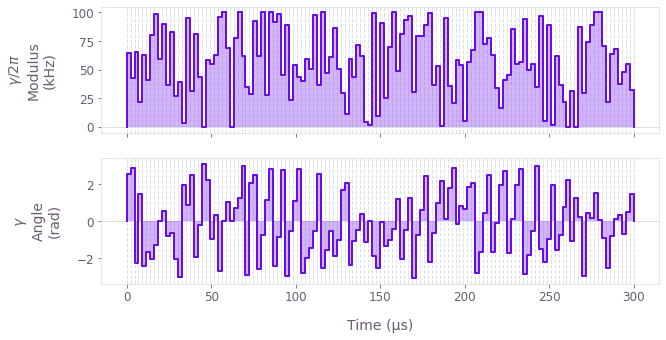

In [5]:
segment_count = 128
sample_times = np.linspace(0, duration, segment_count)
drive_names = [f"ion_drive_{number}" for number in range(ion_count)]

result_optimal = optimization_with_different_drives(
    segment_count=segment_count,
    duration=duration,
    maximum_rabi_rate=maximum_rabi_rate,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    sample_times=sample_times,
    robust=False,
    drive_names=drive_names,
)
print(f"Cost = Infidelity = {result_optimal['output']['infidelity']['value']:.3e}")
qv.plot_controls({"$\\gamma$": result_optimal["output"][drive_names[0]]})

The figure displays the optimized pulse modulus and phase dynamics for ion 0.

### Optimize drives (robust control solution)

To obtain robust controls, we impose symmetry on each drive and optimize such that the centre of mass of each mode's trajectory is at zero.
This is the same procedure as for the two-qubit case described [here](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-error-robust-molmer-sorensen-gates-for-trapped-ions).
In this case, the solution performance is given by the sum of the gate infidelity and the robustness cost.
The robust option is enabled by setting the flag `robust` to True.

Your task (action_id="1827960") is queued.
Your task (action_id="1827960") has started.
Your task (action_id="1827960") has completed.
Cost = 7.460e-08
Infidelity = 9.690e-09


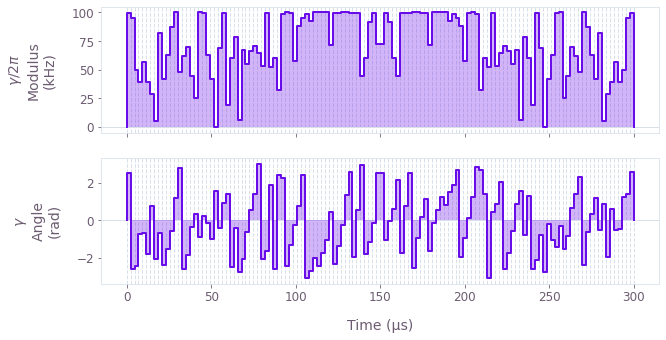

In [6]:
result_robust = optimization_with_different_drives(
    segment_count=segment_count,
    duration=duration,
    maximum_rabi_rate=maximum_rabi_rate,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    sample_times=sample_times,
    robust=True,
    drive_names=drive_names,
)
print(f"Cost = {result_robust['cost']:.3e}")
print(f"Infidelity = {result_robust['output']['infidelity']['value']:.3e}")
qv.plot_controls({"$\\gamma$": result_robust["output"][drive_names[0]]})

The above figure displays the dynamics of the modulus and angle of the robust optimized pulse for ion 0.
The symmetry in time of the modulus values can be observed.

### Performance validation
#### Calculate phase space trajectories

Next, we visualize the trajectory of the center of a coherent state in (rotating) optical phase space for each mode.
Note that there are $3N$ modes in general, where $N$ is the ion number.
We address only the $2N$ transverse modes in the trap.
The closure of these trajectories is a necessary condition for an effective operation.
We first examine the (non-robust) standard optimized control, followed by the robust optimized control.

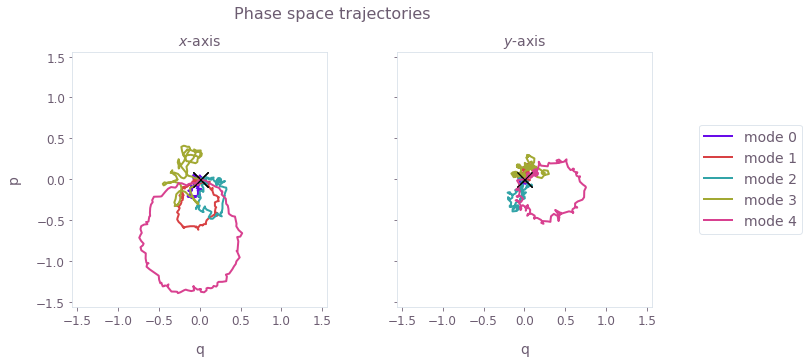

In [7]:
# Sum over ion index to obtain total displacement of the mode.
plot_phase_space_trajectories(
    np.sum(result_optimal["output"]["displacements"]["value"], axis=3)
)

The black cross marks the final displacement for each mode.
These are overlapping at zero, indicating no residual state-motional entanglement and no motional heating caused by the operations.

Now we visualize the phase space trajectories for the robust optimized control.

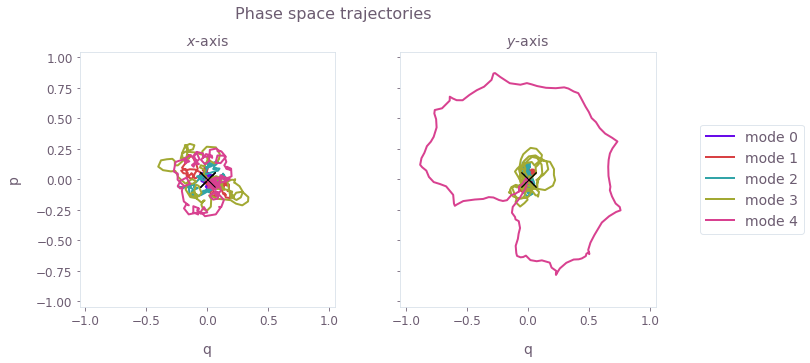

In [8]:
# Sum over ion index to obtain total displacement of the mode.
plot_phase_space_trajectories(
    np.sum(result_robust["output"]["displacements"]["value"], axis=3)
)

Again, the black crosses at the origin indicate no residual state-motional entanglement, which arises from satisfying the center of mass and symmetry conditions.

#### Calculate relative phase dynamics

We can also obtain the phase accumulation for each pair of ions.
The target phases for each pair of ions should be achieved at the end of a successful operation.
First consider the standard optimized control.

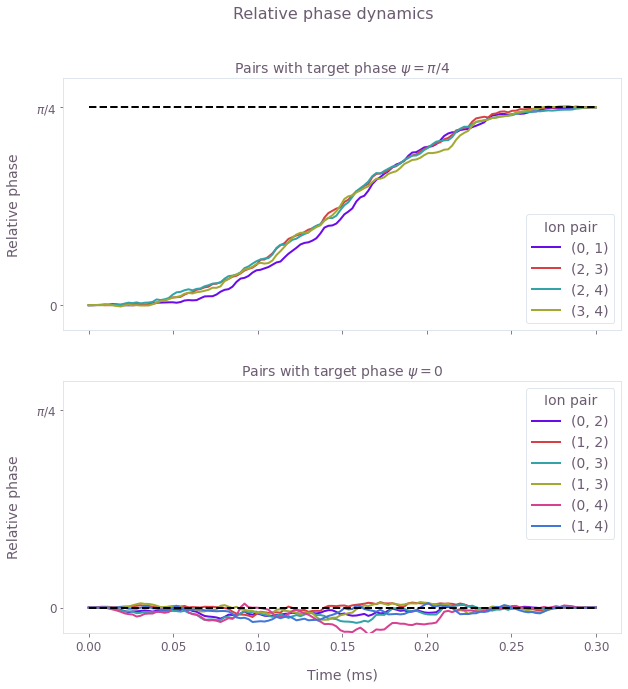

In [9]:
times = sample_times * 1e3
phases = result_optimal["output"]["phases"]["value"]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle("Relative phase dynamics")

target_phases = [psi, 0]
target_phase_names = ["\\pi/4", "0"]

for k in range(2):
    target_phase = target_phases[k]
    for ion1 in range(ion_count):
        for ion2 in range(ion1):
            if target[ion1][ion2] == target_phase:
                axs[k].plot(times, phases[:, ion1, ion2], label=f"{ion2, ion1}")

    axs[k].set_yticks([0, psi])
    axs[k].set_yticklabels([0, "$\\pi/4$"])
    axs[k].set_ylim((-0.1, 0.9))
    axs[k].set_ylabel("Relative phase")
    axs[k].legend(title="Ion pair")

    axs[k].plot([0, times[-1]], [target_phase, target_phase], "k--")
    axs[k].set_title(f"Pairs with target phase $\\psi = {target_phase_names[k]}$")

axs[0].xaxis.set_ticklabels([])
axs[1].set_xlabel("Time (ms)")
plt.show()

These figures display the relative phase dynamics for the duration of the gate operation.
For clarity, different plots display the ion pairs with different target relative phases.
The two plots are for target relative phases of $\pi/4$ and 0, marked with black horizontal dashed lines.

Next consider the phase accumulation for the robust optimized control.

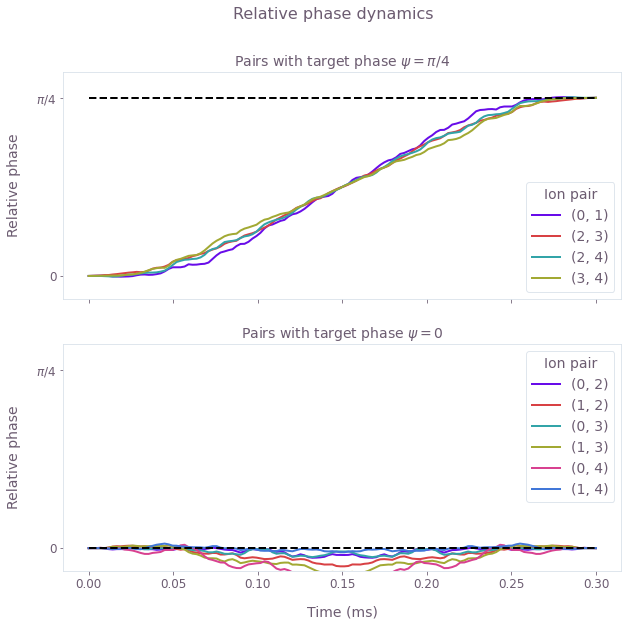

In [10]:
times = sample_times * 1e3
phases = result_robust["output"]["phases"]["value"]

fig, axs = plt.subplots(2, 1, figsize=(10, 9))
fig.suptitle("Relative phase dynamics")

target_phases = [psi, 0]
target_phase_names = ["\\pi/4", "0"]

for k in range(2):
    target_phase = target_phases[k]
    for ion1 in range(ion_count):
        for ion2 in range(ion1):
            if target[ion1][ion2] == target_phase:
                axs[k].plot(times, phases[:, ion1, ion2], label=f"{ion2, ion1}")

    axs[k].set_yticks([0, psi])
    axs[k].set_yticklabels([0, "$\\pi/4$"])
    axs[k].set_ylim((-0.1, 0.9))
    axs[k].set_ylabel("Relative phase")
    axs[k].legend(title="Ion pair")

    axs[k].plot([0, times[-1]], [target_phase, target_phase], "k--")
    axs[k].set_title(f"Pairs with target phase $\\psi = {target_phase_names[k]}$")

axs[0].xaxis.set_ticklabels([])
axs[1].set_xlabel("Time (ms)")
plt.show()

As above, these figures display the relative phase dynamics for the duration of the gate operation.
The two plots are for target relative phases of $\pi/4$ and 0, and these values are marked with black horizontal dashed lines.

The optimized drives produce nontrivial relative phase dynamics for each ion pair since the ions are individually addressed.
The entangling phase is mediated by coupling the ion pairs to shared motional modes, and the optimized drives (both standard and robust) provide the necessary degrees of freedom to achieve the different target relative phases for each ion pair.

#### Calculate robustness to dephasing and pulse timing errors with quasi-static scans

We can assess the robustness of the 'Robust' optimized pulses in comparison to the 'Standard' optimized pulses using 1D quasi-static scans.

First, we calculate a scan of scaling factors for the pulse timings.
The scaling factors are applied uniformly: they scale the timing for the entire operation by the same factor.

In [11]:
scan_point_count = 21

optimal_infidelity_names = [
    f"infidelity_{number}" for number in range(scan_point_count)
]
robust_infidelity_names = [
    f"robust_infidelity_{number}" for number in range(scan_point_count)
]

max_timing_shift = 0.004
time_shifts = np.linspace(1 - max_timing_shift, 1 + max_timing_shift, scan_point_count)

graph = bo.Graph()

for result, infidelity_names in zip(
    [result_optimal, result_robust], [optimal_infidelity_names, robust_infidelity_names]
):
    for time_shift, infidelity_name in zip(time_shifts, infidelity_names):
        drives = [
            graph.pwc(
                durations=time_shift * result["output"][drive_name]["durations"],
                values=result["output"][drive_name]["values"],
            )
            for drive_name in drive_names
        ]
        ms_phases = graph.ions.ms_phases(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
        )

        ms_displacements = graph.ions.ms_displacements(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
        )

        ms_infidelity = graph.ions.ms_infidelity(
            phases=ms_phases,
            displacements=ms_displacements,
            target_phases=target,
            name=infidelity_name,
        )

timing_scan = bo.execute_graph(
    graph, output_node_names=optimal_infidelity_names + robust_infidelity_names
)

optimal_infidelities_timing = [
    timing_scan["output"][name]["value"] for name in optimal_infidelity_names
]
robust_infidelities_timing = [
    timing_scan["output"][name]["value"] for name in robust_infidelity_names
]

Your task (action_id="1827973") is queued.
Your task (action_id="1827973") has started.
Your task (action_id="1827973") has completed.


Next, calculate the robustness of the optimized pulses using a systematic scan of the relative detunings (which corresponds to shifting the laser detuning).

In [12]:
max_dephasing_shift = 0.04 * np.min(np.abs(relative_detunings))
dephasing_shifts = np.linspace(
    -max_dephasing_shift, max_dephasing_shift, scan_point_count
)

graph = bo.Graph()

for result, infidelity_names in zip(
    [result_optimal, result_robust], [optimal_infidelity_names, robust_infidelity_names]
):
    for dephasing_shift, infidelity_name in zip(dephasing_shifts, infidelity_names):
        drives = [
            graph.pwc(**result["output"][drive_name]) for drive_name in drive_names
        ]

        ms_phases = graph.ions.ms_phases(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings + dephasing_shift,
        )
        ms_displacements = graph.ions.ms_displacements(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings + dephasing_shift,
        )
        ms_infidelity = graph.ions.ms_infidelity(
            phases=ms_phases,
            displacements=ms_displacements,
            target_phases=target,
            name=infidelity_name,
        )

dephasing_scan = bo.execute_graph(
    graph, output_node_names=optimal_infidelity_names + robust_infidelity_names
)

optimal_infidelities_dephasing = [
    dephasing_scan["output"][name]["value"] for name in optimal_infidelity_names
]
robust_infidelities_dephasing = [
    dephasing_scan["output"][name]["value"] for name in robust_infidelity_names
]

Your task (action_id="1827976") has started.
Your task (action_id="1827976") has completed.


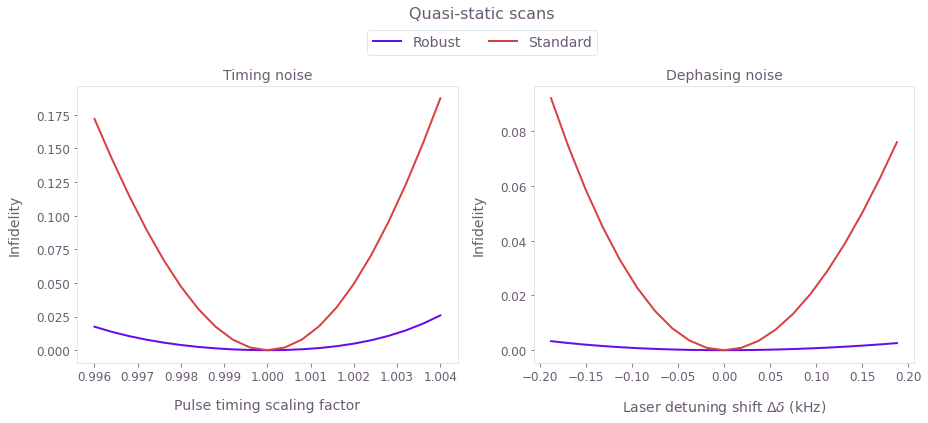

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Quasi-static scans", y=1.1)

axs[0].set_title("Timing noise")
axs[0].plot(time_shifts, robust_infidelities_timing, label="Robust")
axs[0].plot(time_shifts, optimal_infidelities_timing, label="Standard")
axs[0].set_xlabel("Pulse timing scaling factor")
axs[0].set_ylabel("Infidelity")

axs[1].set_title("Dephasing noise")
axs[1].plot(dephasing_shifts / 1e3, robust_infidelities_dephasing, label="Robust")
axs[1].plot(dephasing_shifts / 1e3, optimal_infidelities_dephasing, label="Standard")
axs[1].set_xlabel("Laser detuning shift $\\Delta \\delta$ (kHz)")
axs[1].set_ylabel("Infidelity")

hs, ls = axs[0].get_legend_handles_labels()
fig.legend(handles=hs, labels=ls, loc="center", bbox_to_anchor=(0.5, 1.0), ncol=2)

plt.show()

The broader high-fidelity regions indicate the benefit of the robust optimized pulses when there is quasi-static dephasing noise or noise in the control pulse timings.
The additional robustness for this more general gate is in agreement with published [experimental results](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.13.024022), using related robustness methodology.

## Example: Creating smoothed parallel gates with user-defined entangling phases

In this example we highlight the flexibility of our graph-based computational framework to add several substantial constraints on top of our optimization:

- We generate six parallel pairwise "2-of-12" entangling operations on a 12-ion chain
- Each pair is assigned a different target entangling phase, increasing in steps of 0.2 for each pair
- The high-frequency components of the drive are removed using a sinc filter within the optimizer

In [14]:
# Define trap and laser characteristics.
ion_count = 12
center_of_mass_frequencies = [1.6e6, 1.5e6, 0.25e6]
wavevector = [(2 * np.pi) / 355e-9, (2 * np.pi) / 355e-9, 0]
maximum_rabi_rate = 2 * np.pi * 100e3
laser_detuning = 1.6e6 + 4.7e3

# Calculate Lamb–Dicke parameters and relative detunings.
ion_chain_properties = bo.ions.obtain_ion_chain_properties(
    atomic_mass=171,  # Yb ions
    ion_count=ion_count,
    center_of_mass_frequencies=center_of_mass_frequencies,
    wavevector=wavevector,
    laser_detuning=laser_detuning,
)
lamb_dicke_parameters = ion_chain_properties["lamb_dicke_parameters"]
relative_detunings = ion_chain_properties["relative_detunings"]

Your task (action_id="1827980") has started.
Your task (action_id="1827980") has completed.


In [15]:
# Operation duration.
duration = 3e-4  # s

# Define target phases: element (j,k) is the relative entanglement for ions j and k (k<j).
target = np.zeros((ion_count, ion_count))
for ion1 in range(1, ion_count, 2):
    ion2 = ion1 - 1
    target[ion1][ion2] = ion1 / 10

### Generating optimized pulses

Consider separately-tunable complex drives $\gamma_j (t) = \Omega_j e^{i \phi_j}$ that address each ion $j$ in the trap.
The drives are piecewise-constant with amplitude and phase modulation.
Additionally, a low-pass (sinc) filter is incorporated into the optimizer to smooth the pulse, as required for many practical implementations.

You can set the number of optimized pulse segments and resampling segments for the smoothed pulse, as well as the sinc cutoff frequency in the cell below.

Your task (action_id="1827983") has started.
Your task (action_id="1827983") has completed.
Cost = Infidelity = 4.023e-06


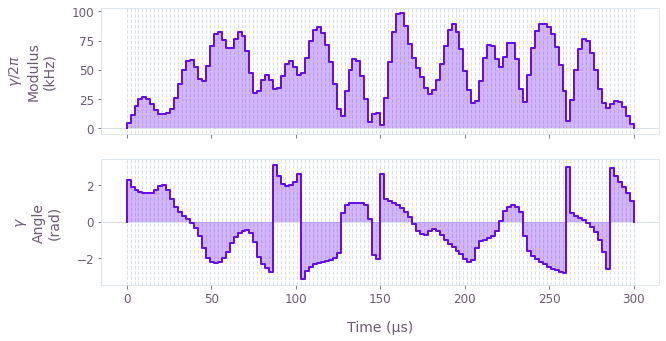

In [16]:
segment_count = 32
sample_count = 128
sample_times = np.linspace(0, duration, sample_count)
cutoff_frequency = 2 * np.pi * 0.05e6
drive_names = [f"ion_drive_{number}" for number in range(ion_count)]

graph = bo.Graph()

drives = []

for drive_name in drive_names:
    drive_raw_real = graph.real_optimizable_pwc_signal(
        segment_count=segment_count,
        duration=duration,
        maximum=maximum_rabi_rate,
        minimum=-maximum_rabi_rate,
    )
    drive_raw_imag = graph.real_optimizable_pwc_signal(
        segment_count=segment_count,
        duration=duration,
        maximum=maximum_rabi_rate,
        minimum=-maximum_rabi_rate,
    )
    drives.append(
        graph.filter_and_resample_pwc(
            pwc=drive_raw_real + 1j * drive_raw_imag,
            kernel=graph.sinc_convolution_kernel(cutoff_frequency),
            segment_count=sample_count,
            name=drive_name,
        )
    )

ms_phases = graph.ions.ms_phases(
    drives=drives,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
)

ms_displacements = graph.ions.ms_displacements(
    drives=drives,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
)

infidelity = graph.ions.ms_infidelity(
    phases=ms_phases,
    displacements=ms_displacements,
    target_phases=target,
    name="infidelity",
)

result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=["infidelity"] + drive_names,
    optimization_count=4,
)
print(f"Cost = Infidelity = {result['output']['infidelity']['value']:.3e}")
qv.plot_controls({"$\\gamma$": result["output"]["ion_drive_0"]})

The above figure displays the optimized smooth pulse modulus and phase dynamics for ion 0, as an example of the ion-specific drives.

### Performance validation
#### Calculate phase space trajectories

For a system as large as this, you can separate the simulation of the displacement from the optimization to increase the efficiency.
This procedure is demonstrated in the [How to calculate system dynamics for arbitrary Mølmer–Sørensen gates](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-calculate-system-dynamics-for-arbitrary-molmer-sorensen-gates) user guide.

In [17]:
graph = bo.Graph()

drives = [graph.pwc(**result["output"][drive_name]) for drive_name in drive_names]

ms_displacements = graph.ions.ms_displacements(
    drives=drives,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    sample_times=sample_times,
    name="displacements",
)

displacement_simulation = bo.execute_graph(graph, "displacements")

Your task (action_id="1827986") has started.
Your task (action_id="1827986") has completed.


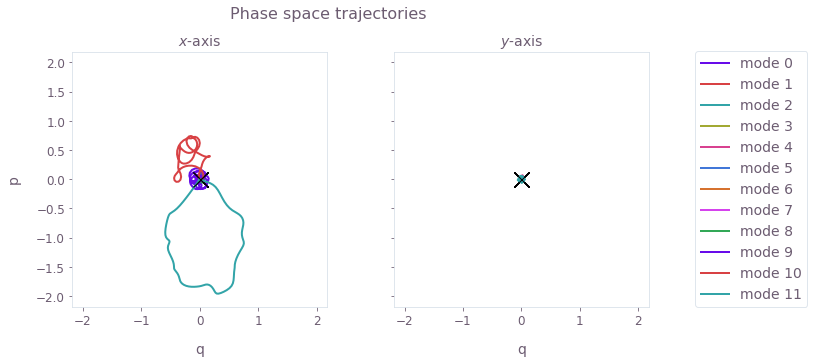

In [18]:
# Sum over ion index to obtain total displacement of the mode.
plot_phase_space_trajectories(
    np.sum(displacement_simulation["output"]["displacements"]["value"], axis=3)
)

The black cross marks the final displacement for each mode.
These are overlapping at zero, indicating no residual state-motional entanglement and no motional heating caused by the operations.

#### Calculate relative phase dynamics

The target phases for each pair of ions should be achieved at the end of a successful operation.
Again, for a system as large as this, you can separate the simulation of the phases from the optimization, to increase the efficiency.

In [19]:
graph = bo.Graph()

drives = [graph.pwc(**result["output"][drive_name]) for drive_name in drive_names]

ms_phases = graph.ions.ms_phases(
    drives=drives,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    sample_times=sample_times,
    name="phases",
)

phase_simulation = bo.execute_graph(graph, "phases")

phases = phase_simulation["output"]["phases"]["value"]

Your task (action_id="1827989") is queued.
Your task (action_id="1827989") has started.
Your task (action_id="1827989") has completed.


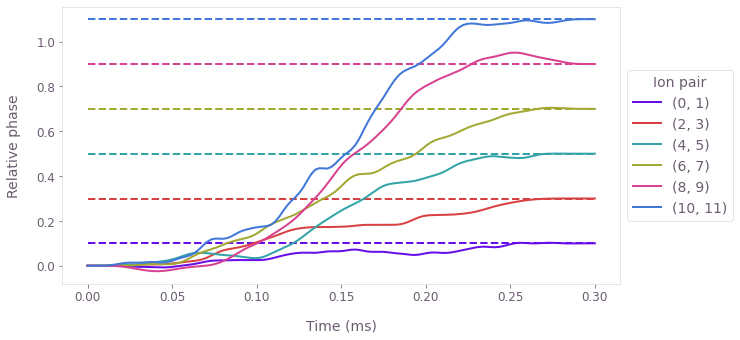

In [20]:
times = sample_times * 1e3

for ion1, color in zip(range(1, ion_count, 2), qv.QCTRL_STYLE_COLORS):
    ion2 = ion1 - 1
    plt.plot(times, phases[:, ion1, ion2], label=f"{ion2, ion1}", color=color)
    plt.plot(
        [0, times[-1]], [target[ion1][ion2], target[ion1][ion2]], "--", color=color
    )

plt.xlabel("Time (ms)")
plt.ylabel("Relative phase")
plt.legend(title="Ion pair", loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

The figure displays the relative phase dynamics for each entangled ion pair, with a color matched to the pair's target relative phase (dashed).
Note that by the end of the operation, each ion pair achieves its specified, distinct relative phase target.